In [ ]:
# from google.colab import files
# files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"zaurasgarli","key":"2c87cf0d0f15f442ff94298c92280127"}'}

In [ ]:
# !mkdir ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# !kaggle datasets download -d prithivsakthiur/deepfake-vs-real-60k

In [ ]:
# !unzip -q /content/deepfake-vs-real-60k.zip

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("prithivsakthiur/deepfake-vs-real-60k")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/deepfake-vs-real-60k


In [ ]:
import shutil
import os

#read-only
src_dir = path

dst_dir = "/content/deepfake-vs-real-60k"

shutil.copytree(src_dir, dst_dir)

print(f"Dataset copied to: {dst_dir}")

Dataset copied to: /content/deepfake-vs-real-60k


In [ ]:
import tensorflow as tf

main_folder = '/content/deepfake-vs-real-60k/deepfake-vs-real-60k'


dataset = tf.keras.utils.image_dataset_from_directory(
    main_folder,
    image_size=(224, 224),
    batch_size=32
)

Found 57071 files belonging to 2 classes.


In [ ]:
import matplotlib.pyplot as plt

for images, labels in dataset.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(dataset.class_names[labels[i]])
        plt.axis("off")

In [ ]:
!pip install imagehash Pillow tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.7/296.7 kB 8.1 MB/s eta 0:00:00


In [ ]:
import hashlib
from PIL import Image
import os
from collections import defaultdict
from tqdm import tqdm

def hash_image(img_path):
    try:
        with Image.open(img_path).resize((64, 64)) as img:
            return hashlib.md5(img.tobytes()).hexdigest()
    except Exception as e:
        print(f"Error hashing {img_path}: {e}")
        return None

hash_dict = defaultdict(list)

# Scan all images and group them by their hash
for root, _, files in tqdm(list(os.walk(main_folder))):
    for file in files:
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(root, file)
            hash_val = hash_image(img_path)
            if hash_val:
                hash_dict[hash_val].append(img_path)

# Find hashes with more than 1 file → duplicates
duplicate_groups = {h: paths for h, paths in hash_dict.items() if len(paths) > 1}

print(f"\nFound {len(duplicate_groups)} sets of exact duplicate images.\n")

for h, paths in duplicate_groups.items():
    print(f"\nHash: {h}")
    print(f"Keeping: {paths[0]}")  # keep the first image
    for p in paths[1:]:
        print(f"Removing duplicate: {p}")
        try:
            os.remove(p)
        except Exception as e:
            print(f"Failed to remove {p}: {e}")


100%|██████████| 3/3 [18:53<00:00, 377.92s/it]


Found 174 sets of exact duplicate images.


Hash: c98f8989c861500372af215683a0184f
Keeping: /content/deepfake-vs-real-60k/deepfake-vs-real-60k/Fake/0001 (19326).jpg
Removing duplicate: /content/deepfake-vs-real-60k/deepfake-vs-real-60k/Fake/0001 (19330).jpg

Hash: e870070bd40c6dc9f0a9130761cd86fb
Keeping: /content/deepfake-vs-real-60k/deepfake-vs-real-60k/Fake/0001 (12721).jpg
Removing duplicate: /content/deepfake-vs-real-60k/deepfake-vs-real-60k/Fake/0001 (14071).jpg

Hash: ffd148e3a1a414e460cf82caa68fc755
Keeping: /content/deepfake-vs-real-60k/deepfake-vs-real-60k/Fake/0001 (2386).jpg
Removing duplicate: /content/deepfake-vs-real-60k/deepfake-vs-real-60k/Fake/0001 (2384).jpg

Hash: bbc354c4392226c21e2f67a78b85b302
Keeping: /content/deepfake-vs-real-60k/deepfake-vs-real-60k/Fake/0001 (19384).jpg
Removing duplicate: /content/deepfake-vs-real-60k/deepfake-vs-real-60k/Fake/0001 (19715).jpg

Hash: 22af38dfd4348b851af03b10fd496362
Keeping: /content/deepfake-vs-real-60k/deepfake-vs-real-60

In [ ]:
import os
from PIL import Image
import imagehash
from tqdm import tqdm
from collections import defaultdict
import concurrent.futures

hash_size = 8
resize_size = (64, 64)
threshold = 5  # Hamming distance threshold for similarity
prefix_len = 3  # Number of characters from hash to group (e.g. hash[:3])

image_paths = []
for root, _, files in os.walk(main_folder):
    for file in files:
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_paths.append(os.path.join(root, file))

def compute_hash(path):
    try:
        with Image.open(path).convert('RGB').resize(resize_size) as img:
            ahash = imagehash.average_hash(img, hash_size=hash_size)
            return (str(ahash), path)
    except:
        return None

with concurrent.futures.ThreadPoolExecutor(max_workers=8) as executor:
    results = list(tqdm(executor.map(compute_hash, image_paths), total=len(image_paths)))

prefix_bins = defaultdict(list)
hash_map = {}

for result in results:
    if result:
        h, path = result
        prefix_bins[h[:prefix_len]].append((h, path))
        hash_map.setdefault(h, []).append(path)

visited = set()
clusters = []

for bin_group in tqdm(prefix_bins.values(), desc="Clustering"):
    for i in range(len(bin_group)):
        hash1, path1 = bin_group[i]
        if path1 in visited:
            continue
        cluster = [path1]
        visited.add(path1)
        hash1_obj = imagehash.hex_to_hash(hash1)

        for j in range(i + 1, len(bin_group)):
            hash2, path2 = bin_group[j]
            if path2 in visited:
                continue
            dist = hash1_obj - imagehash.hex_to_hash(hash2)
            if dist <= threshold:
                cluster.append(path2)
                visited.add(path2)

        if len(cluster) > 1:
            clusters.append(cluster)

print(f"\nFound {len(clusters)} clusters of near-duplicate images.\n")

for cluster in clusters:
    print(f"Keeping: {cluster[0]}")
    for dup in cluster[1:]:
        try:
            os.remove(dup)
            print(f"Removed: {dup}")
        except Exception as e:
            print(f"Error deleting {dup}: {e}")


Clustering: 100%|██████████| 2656/2656 [06:10<00:00,  7.16it/s]  


Streaming output truncated to the last 5000 lines.
Removed: /content/deepfake-vs-real-60k/deepfake-vs-real-60k/Real/0001 (11285).png
Keeping: /content/deepfake-vs-real-60k/deepfake-vs-real-60k/Real/0001 (20153).png
Removed: /content/deepfake-vs-real-60k/deepfake-vs-real-60k/Real/0001 (23350).png
Removed: /content/deepfake-vs-real-60k/deepfake-vs-real-60k/Real/0001 (22386).png
Keeping: /content/deepfake-vs-real-60k/deepfake-vs-real-60k/Real/0001 (2102).png
Removed: /content/deepfake-vs-real-60k/deepfake-vs-real-60k/Real/0001 (25117).png
Removed: /content/deepfake-vs-real-60k/deepfake-vs-real-60k/Real/0001 (18958).png
Removed: /content/deepfake-vs-real-60k/deepfake-vs-real-60k/Fake/0001 (28551).jpg
Keeping: /content/deepfake-vs-real-60k/deepfake-vs-real-60k/Real/0001 (21033).png
Removed: /content/deepfake-vs-real-60k/deepfake-vs-real-60k/Real/0001 (1440).png
Removed: /content/deepfake-vs-real-60k/deepfake-vs-real-60k/Real/0001 (5525).png
Removed: /content/deepfake-vs-real-60k/deepfake-vs

In [ ]:
val_split = 0.2
batch_size = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    main_folder,
    validation_split=val_split,
    subset="training",
    seed=42,
    image_size=(224, 224),
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    main_folder,
    validation_split=val_split,
    subset="validation",
    seed=42,
    image_size=(224, 224),
    batch_size=batch_size
)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

Found 50843 files belonging to 2 classes.
Using 40675 files for training.
Found 50843 files belonging to 2 classes.
Using 10168 files for validation.


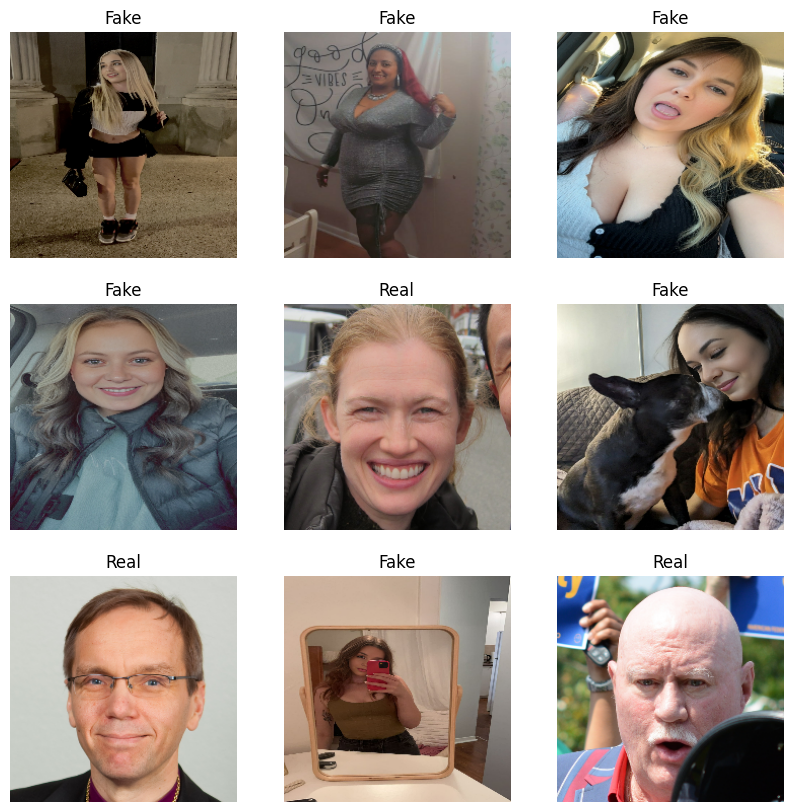

In [ ]:
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(dataset.class_names[labels[i]])
        plt.axis("off")

In [ ]:
from tensorflow.keras import layers
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),  # flip horizontally and vertically
    layers.RandomRotation(0.2),                    # rotate by ±20%
    layers.RandomZoom(0.1),                        # zoom in/out by ±10%
    layers.RandomContrast(0.1),                    # adjust contrast by ±10%
    layers.RandomTranslation(0.1, 0.1)             # translate horizontally and vertically by ±10%
])

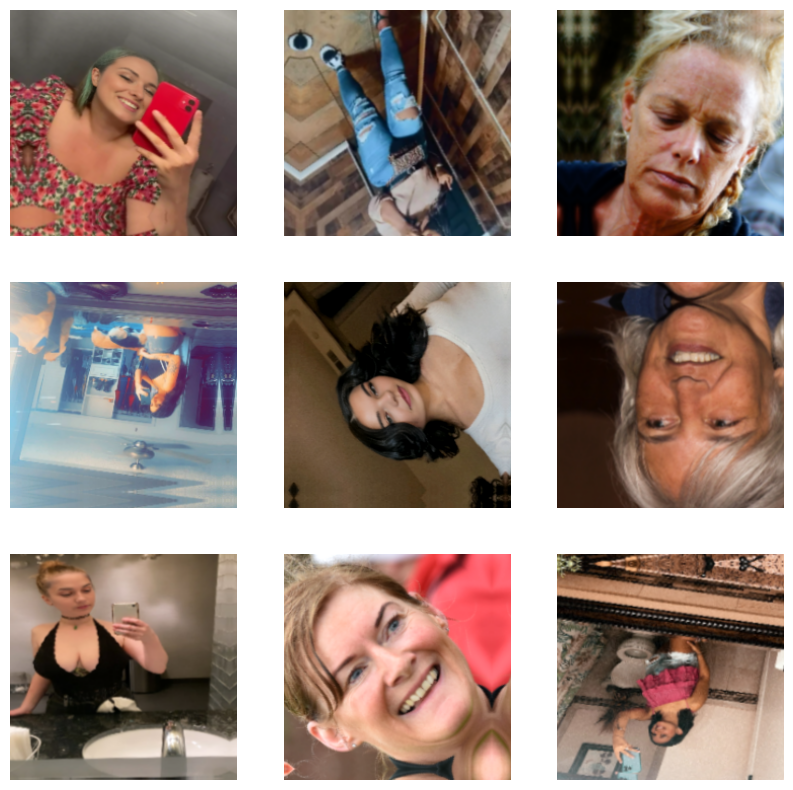

In [ ]:
for images, _ in train_ds.take(1):
    augmented = data_augmentation(images)

    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented[i].numpy().astype("uint8"))
        plt.axis("off")
    break


In [ ]:
l2 = tf.keras.regularizers.l2(0.001)
base_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(224, 224, 3)),
    tf.keras.layers.Rescaling(1./255),
    data_augmentation,

    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=l2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


base_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history = base_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
)

Epoch 1/5
1272/1272 ━━━━━━━━━━━━━━━━━━━━ 76s 54ms/step - accuracy: 0.7317 - loss: 0.6587 - val_accuracy: 0.8234 - val_loss: 0.4191
Epoch 2/5
1272/1272 ━━━━━━━━━━━━━━━━━━━━ 68s 53ms/step - accuracy: 0.8330 - loss: 0.4152 - val_accuracy: 0.8681 - val_loss: 0.3357
Epoch 3/5
1272/1272 ━━━━━━━━━━━━━━━━━━━━ 68s 53ms/step - accuracy: 0.8412 - loss: 0.3992 - val_accuracy: 0.8780 - val_loss: 0.3254
Epoch 4/5
1272/1272 ━━━━━━━━━━━━━━━━━━━━ 67s 53ms/step - accuracy: 0.8582 - loss: 0.3687 - val_accuracy: 0.8991 - val_loss: 0.2862
Epoch 5/5
1272/1272 ━━━━━━━━━━━━━━━━━━━━ 68s 53ms/step - accuracy: 0.8714 - loss: 0.3456 - val_accuracy: 0.8908 - val_loss: 0.3039


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step


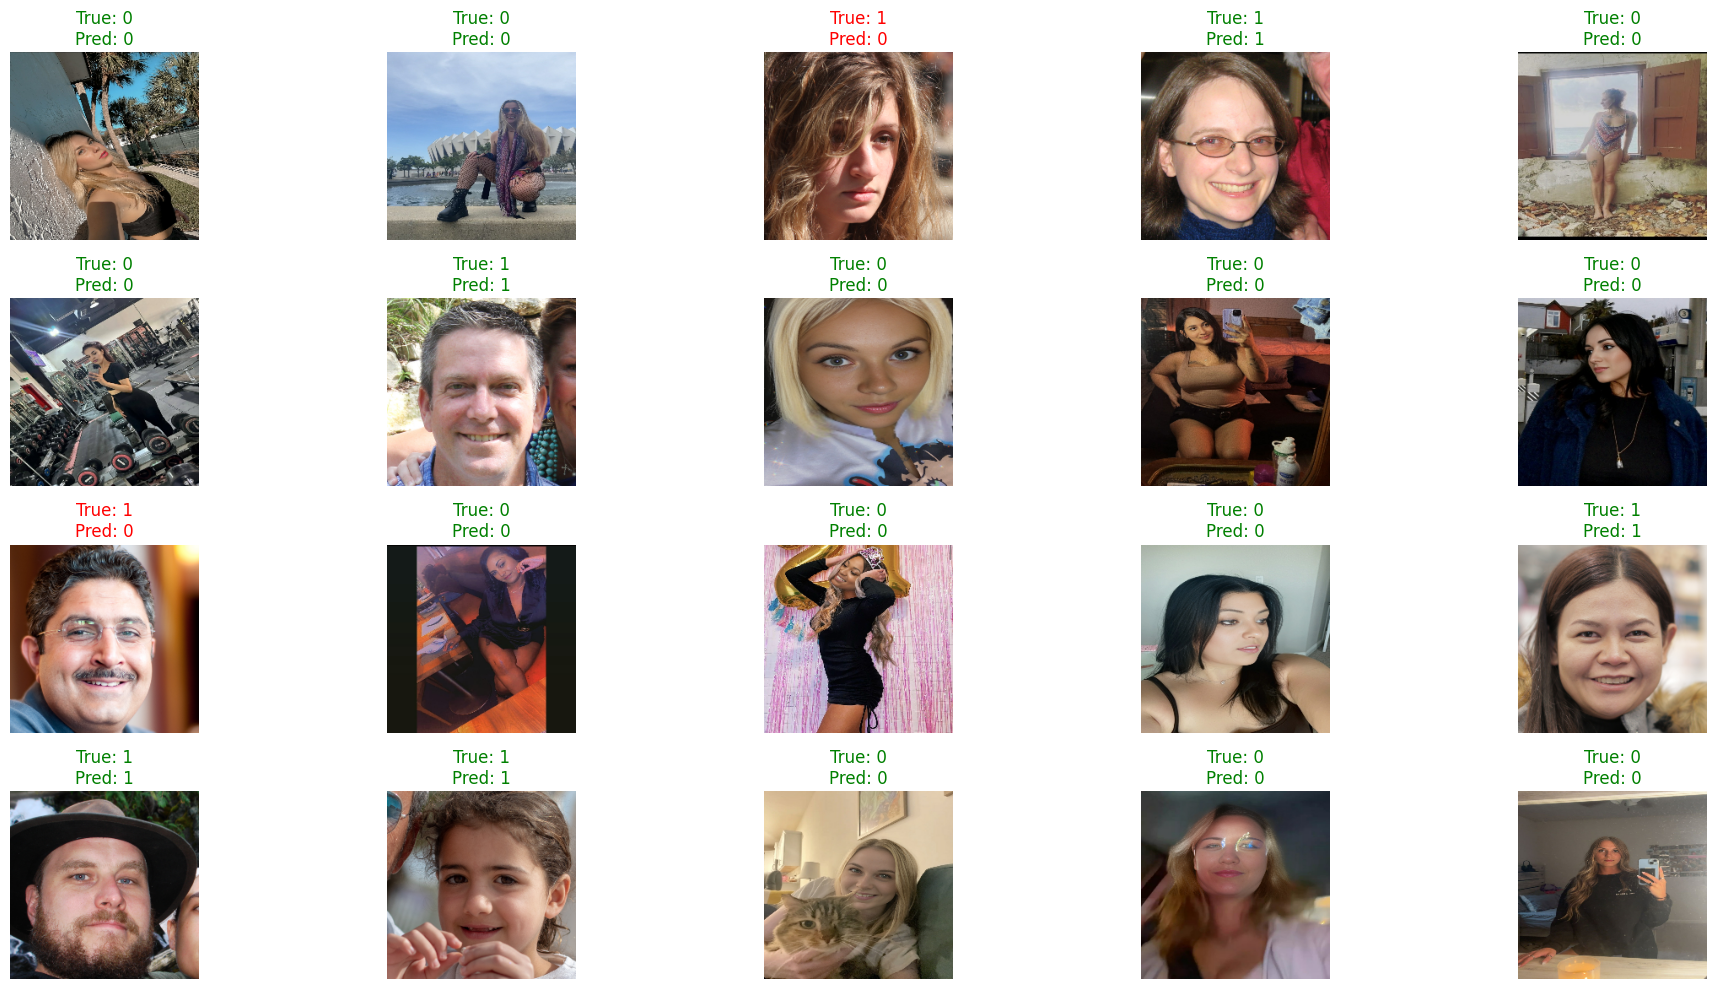

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Collect 20 images and labels from validation dataset
images = []
labels = []

for img_batch, label_batch in val_ds.unbatch().batch(1).take(20):
    images.append(img_batch[0].numpy())
    labels.append(label_batch[0].numpy())

images = np.array(images)
labels = np.array(labels)

# Predict on these images
preds = base_model.predict(images)
pred_labels = (preds > 0.5).astype(int).flatten()

# Plot
plt.figure(figsize=(20, 10))
for i in range(20):
    plt.subplot(4, 5, i+1)
    plt.imshow(images[i].astype("uint8"))
    plt.axis('off')
    title_color = 'green' if pred_labels[i] == labels[i] else 'red'
    plt.title(f"True: {labels[i]}\nPred: {pred_labels[i]}", color=title_color)
plt.tight_layout()
plt.show()

In [ ]:
images = []

for img_batch, label_batch in val_ds.unbatch().batch(1).take(20):
    images.append(img_batch[0].numpy())

images = np.array(images)

preds = base_model.predict(images)
preds

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


array([[4.3718625e-02],
       [1.9519327e-03],
       [2.3005698e-03],
       [1.4487071e-03],
       [1.5189842e-04],
       [1.4723460e-01],
       [3.2184362e-01],
       [4.4867015e-06],
       [9.6724427e-01],
       [7.4844020e-03],
       [3.4668259e-02],
       [3.5008814e-02],
       [7.8146430e-03],
       [8.8400871e-01],
       [2.1674125e-03],
       [9.7255176e-01],
       [2.3296301e-03],
       [8.0798262e-01],
       [3.3718816e-03],
       [9.7647107e-01]], dtype=float32)

In [ ]:
inputs = tf.keras.layers.Input(shape=(224, 224, 3))

x = data_augmentation(inputs)
x = tf.keras.applications.densenet.preprocess_input(x)

base_model = tf.keras.applications.DenseNet201(include_top=False, input_tensor=x)

base_model.trainable = False

avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)

x = layers.Dropout(0.3)(avg)

output = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model_dense = tf.keras.Model(inputs=inputs, outputs=output)


optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

model_dense.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy']
)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

check_point = tf.keras.callbacks.ModelCheckpoint(filepath='best_model.keras', monitor='val_loss', save_best_only=True)

history_dense = model_dense.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[early_stop, check_point]
)

74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20
1272/1272 ━━━━━━━━━━━━━━━━━━━━ 207s 146ms/step - accuracy: 0.8856 - loss: 0.2657 - val_accuracy: 0.9732 - val_loss: 0.0769
Epoch 2/20
1272/1272 ━━━━━━━━━━━━━━━━━━━━ 177s 139ms/step - accuracy: 0.9521 - loss: 0.1263 - val_accuracy: 0.9803 - val_loss: 0.0562
Epoch 3/20
1272/1272 ━━━━━━━━━━━━━━━━━━━━ 177s 139ms/step - accuracy: 0.9563 - loss: 0.1140 - val_accuracy: 0.9825 - val_loss: 0.0510
Epoch 4/20
1272/1272 ━━━━━━━━━━━━━━━━━━━━ 178s 140ms/step - accuracy: 0.9559 - loss: 0.1136 - val_accuracy: 0.9843 - val_loss: 0.0465
Epoch 5/20
1272/1272 ━━━━━━━━━━━━━━━━━━━━ 176s 138ms/step - accuracy: 0.9578 - loss: 0.1099 - val_accuracy: 0.9773 - val_loss: 0.0607
Epoch 6/20
1272/1272 ━━━━━━━━━━━━━━━━━━━━ 178s 140ms/step - accuracy: 0.9566 - loss: 0.1138 - val_accuracy: 0.9839 - val_loss: 0.0455
Epoch 7/20
1272/1272 ━━━━━━━━━━━━━━━━━━━━ 176s 138ms/step - accuracy: 0.9570 - loss: 0.1082 - val_accuracy: 0.9787 - val_loss: 0.0585
Epoch 8/20


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from functools import partial

DefaultConv2D = partial(
    tf.keras.layers.Conv2D,
    kernel_size=3,
    strides=1,
    padding='same',
    kernel_initializer='he_normal',
    use_bias=False
)

def swish(x):
    return x * tf.keras.activations.sigmoid(x)

class MBConvBlock(tf.keras.layers.Layer):
    def __init__(self, filters, expansion_factor=6, kernel_size=3, strides=1, se_ratio=0.25, drop_rate=0.0):
        super().__init__()
        self.filters = filters
        self.expansion_factor = expansion_factor
        self.kernel_size = kernel_size
        self.strides = strides
        self.se_ratio = se_ratio
        self.drop_rate = drop_rate

    def build(self, input_shape):
        input_channels = input_shape[-1]
        expanded_channels = input_channels * self.expansion_factor

        self.expand_conv = DefaultConv2D(expanded_channels, kernel_size=1, strides=1)
        self.bn0 = layers.BatchNormalization()

        self.dw_conv = layers.DepthwiseConv2D(kernel_size=self.kernel_size, strides=self.strides, padding='same', use_bias=False)
        self.bn1 = layers.BatchNormalization()

        se_channels = max(1, int(input_channels * self.se_ratio))
        self.se_avg_pool = layers.GlobalAveragePooling2D()
        self.se_reduce = layers.Dense(se_channels, activation='relu')
        self.se_expand = layers.Dense(expanded_channels, activation='sigmoid')

        self.project_conv = DefaultConv2D(self.filters, kernel_size=1, strides=1)
        self.bn2 = layers.BatchNormalization()

        self.dropout = layers.Dropout(self.drop_rate)
        self.swish = tf.keras.layers.Activation(swish)

    def call(self, inputs, training=False):
        x = self.expand_conv(inputs)
        x = self.bn0(x, training=training)
        x = self.swish(x)

        x = self.dw_conv(x)
        x = self.bn1(x, training=training)
        x = self.swish(x)

        se = self.se_avg_pool(x)
        se = layers.Reshape((1,1,se.shape[1]))(se)
        se = self.se_reduce(se)
        se = self.se_expand(se)
        x = layers.Multiply()([x, se])

        x = self.project_conv(x)
        x = self.bn2(x, training=training)

        if inputs.shape == x.shape and self.strides == 1:
            x = layers.Add()([x, inputs])

        x = self.dropout(x, training=training)
        return x

inputs = tf.keras.Input(shape=(224, 224, 3))
x = DefaultConv2D(40, strides=2)(inputs)
x = layers.BatchNormalization()(x)
x = layers.Activation(swish)(x)

x = MBConvBlock(24, expansion_factor=1, kernel_size=3)(x)
x = MBConvBlock(24, expansion_factor=1, kernel_size=3)(x)

x = MBConvBlock(32, kernel_size=3, strides=2)(x)
x = MBConvBlock(32, kernel_size=3)(x)

x = MBConvBlock(48, kernel_size=5, strides=2)(x)
x = MBConvBlock(48, kernel_size=5)(x)
x = MBConvBlock(48, kernel_size=5)(x)

x = MBConvBlock(96, kernel_size=3, strides=2)(x)
x = MBConvBlock(96, kernel_size=3)(x)
x = MBConvBlock(96, kernel_size=3)(x)

x = MBConvBlock(136, kernel_size=5)(x)
x = MBConvBlock(136, kernel_size=5)(x)
x = MBConvBlock(136, kernel_size=5)(x)
x = MBConvBlock(136, kernel_size=5)(x)
x = MBConvBlock(136, kernel_size=5)(x)

x = MBConvBlock(232, kernel_size=5, strides=2)(x)
for _ in range(5):
    x = MBConvBlock(232, kernel_size=5)(x)

# Stage 7
x = MBConvBlock(384, kernel_size=3)(x)
x = MBConvBlock(384, kernel_size=3)(x)

# Head
x = layers.Conv2D(1536, kernel_size=1, use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation(swish)(x)

x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model_effb3 = tf.keras.Model(inputs, outputs, name="EfficientNetB3_Custom")

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

model_effb3.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy']
)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

check_point = tf.keras.callbacks.ModelCheckpoint(filepath='best_model.keras', monitor='val_loss', save_best_only=True)

history_effb3 = model_effb3.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[early_stop, check_point]
)

Epoch 1/20
1272/1272 ━━━━━━━━━━━━━━━━━━━━ 358s 201ms/step - accuracy: 0.9075 - loss: 0.2115 - val_accuracy: 0.9664 - val_loss: 0.1438
Epoch 2/20
1272/1272 ━━━━━━━━━━━━━━━━━━━━ 184s 145ms/step - accuracy: 0.9908 - loss: 0.0307 - val_accuracy: 0.9809 - val_loss: 0.0614
Epoch 3/20
1272/1272 ━━━━━━━━━━━━━━━━━━━━ 184s 144ms/step - accuracy: 0.9955 - loss: 0.0150 - val_accuracy: 0.9968 - val_loss: 0.0106
Epoch 4/20
1272/1272 ━━━━━━━━━━━━━━━━━━━━ 183s 144ms/step - accuracy: 0.9972 - loss: 0.0092 - val_accuracy: 0.9910 - val_loss: 0.0303
Epoch 5/20
1272/1272 ━━━━━━━━━━━━━━━━━━━━ 182s 143ms/step - accuracy: 0.9954 - loss: 0.0162 - val_accuracy: 0.9934 - val_loss: 0.0189
Epoch 6/20
1272/1272 ━━━━━━━━━━━━━━━━━━━━ 183s 144ms/step - accuracy: 0.9974 - loss: 0.0085 - val_accuracy: 0.9983 - val_loss: 0.0052
Epoch 7/20
1272/1272 ━━━━━━━━━━━━━━━━━━━━ 183s 143ms/step - accuracy: 0.9981 - loss: 0.0063 - val_accuracy: 0.9976 - val_loss: 0.0079
Epoch 8/20
1272/1272 ━━━━━━━━━━━━━━━━━━━━ 181s 143ms/step - ac

In [ ]:
import matplotlib.pyplot as plt

def plot_training_curves(history, title="Training Curves"):
    acc = history.history.get('accuracy')
    val_acc = history.history.get('val_accuracy')
    loss = history.history.get('loss')
    val_loss = history.history.get('val_loss')
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14,5))

    plt.subplot(1,2,1)
    plt.plot(epochs, acc, 'b-', label='Train Accuracy')
    plt.plot(epochs, val_acc, 'r--', label='Validation Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.subplot(1,2,2)
    plt.plot(epochs, loss, 'b-', label='Train Loss')
    plt.plot(epochs, val_loss, 'r--', label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.show()


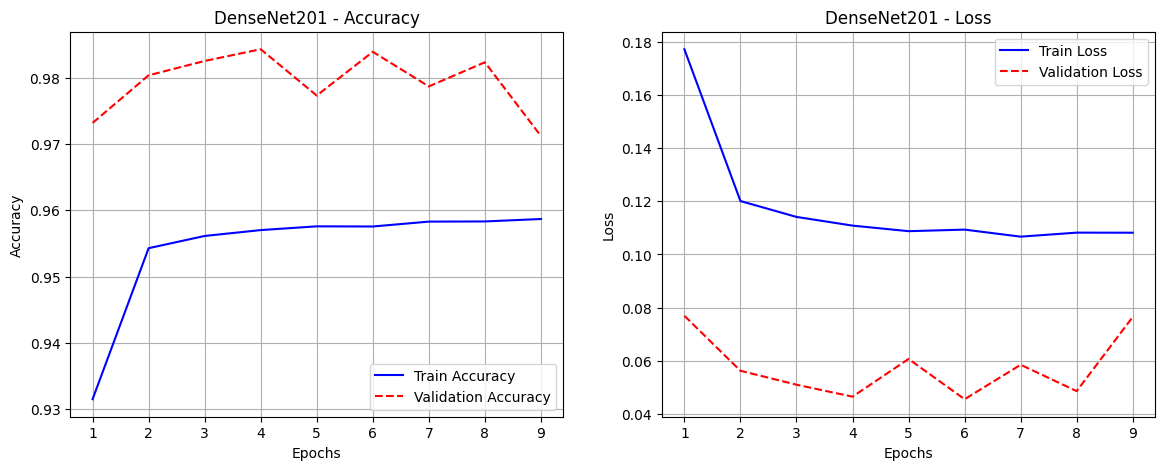

In [ ]:
plot_training_curves(history_dense, title="DenseNet201")

In [ ]:
plot_training_curves(history_effb3, title="EfficientNetB3")

In [ ]:
import numpy as np

images = []
labels = []

for img_batch, label_batch in val_ds.unbatch().batch(1).take(20):
    images.append(img_batch[0].numpy())
    labels.append(label_batch[0].numpy())

images = np.array(images)
labels = np.array(labels)

preds = model_dense.predict(images)
pred_labels = (preds > 0.5).astype(int).flatten()

plt.figure(figsize=(20, 10))
for i in range(20):
    plt.subplot(4, 5, i+1)
    plt.imshow(images[i].astype("uint8"))
    plt.axis('off')
    title_color = 'green' if pred_labels[i] == labels[i] else 'red'
    plt.title(f"True: {labels[i]}\nPred: {pred_labels[i]}", color=title_color)
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
